In [ ]:
!pip install transformers

In [ ]:
!pip install bert-tensorflow==1.0.1

In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [5]:
import numpy as np
import os
import collections
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
from bert import modeling

In [6]:
import pickle

In [7]:
flattened = pd.read_pickle("/content/drive/My Drive/Stack_Overflow/flattened.pkl")
flattened.shape

(706333, 11)

In [8]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(flattened,test_size=0.3)

In [9]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-11-04 06:22:47--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.20.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   230MB/s    in 1.7s    

2020-11-04 06:22:49 (230 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [10]:
!unzip /content/uncased_L-12_H-768_A-12.zip

Archive:  /content/uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [11]:
tokenization.validate_case_matches_checkpoint(True,'/content/uncased_L-12_H-768_A-12/bert_model.ckpt.index')

In [12]:
tokenizer = tokenization.FullTokenizer(vocab_file='/content/uncased_L-12_H-768_A-12/vocab.txt', do_lower_case=True)

In [13]:
len(tokenizer.vocab)

30522

In [14]:
DATA_COLUMN = 'Title & Body'
LABEL_COLUMNS = ['android', 'c#', 'c++', 'html', 'ios', 'java','javascript', 'jquery', 'php', 'python']

In [15]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, labels=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            labels: (Optional) [string]. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.labels = labels


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids, is_real_example=True):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids,
        self.is_real_example=is_real_example

In [16]:
def create_examples(df, labels_available=True):
    """Creates examples for the training and dev sets."""
    examples = []
    for (i, row) in enumerate(df.values):
        guid = None
        text_a = row[0]
        if labels_available:
            labels = row[1:]
        else:
            labels = [0,0,0,0,0,0,0,0,0,0]
        examples.append(
            InputExample(guid=guid, text_a=text_a, labels=labels))
    return examples

In [17]:
TRAIN_VAL_RATIO = 0.9
LEN = train.shape[0]
SIZE_TRAIN = int(TRAIN_VAL_RATIO*LEN)

x_train = train[:SIZE_TRAIN]
x_val = train[SIZE_TRAIN:]

train_examples = create_examples(x_train)

In [80]:
def convert_examples_to_features(examples,  max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    features = []
    for (ex_index, example) in enumerate(examples):
        #print(example.text_a)
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        
        labels_ids = []
        for label in example.labels:
            labels_ids.append(int(label))

        if ex_index < 0:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %s)" % (example.labels, labels_ids))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_ids=labels_ids))
    return features

In [19]:
# We'll set sequences to be at most 256 tokens long.
MAX_SEQ_LENGTH = 256

In [20]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 10000
SAVE_SUMMARY_STEPS = 500

In [21]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
    When running eval/predict on the TPU, we need to pad the number of examples
    to be a multiple of the batch size, because the TPU requires a fixed batch
    size. The alternative is to drop the last batch, which is bad because it means
    the entire output data won't be generated.
    We use this class instead of `None` because treating `None` as padding
    battches could cause silent errors.
    """
    
    
def convert_single_example(ex_index, example, max_seq_length,
                           tokenizer):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        return InputFeatures(
            input_ids=[0] * max_seq_length,
            input_mask=[0] * max_seq_length,
            segment_ids=[0] * max_seq_length,
            label_ids=0,
            is_real_example=False)

    tokens_a = tokenizer.tokenize(example.text_a)
    tokens_b = None
    if example.text_b:
        tokens_b = tokenizer.tokenize(example.text_b)

    if tokens_b:
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
    else:
        # Account for [CLS] and [SEP] with "- 2"
        if len(tokens_a) > max_seq_length - 2:
            tokens_a = tokens_a[0:(max_seq_length - 2)]

    # The convention in BERT is:
    # (a) For sequence pairs:
    #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
    #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
    # (b) For single sequences:
    #  tokens:   [CLS] the dog is hairy . [SEP]
    #  type_ids: 0     0   0   0  0     0 0
    #
    # Where "type_ids" are used to indicate whether this is the first
    # sequence or the second sequence. The embedding vectors for `type=0` and
    # `type=1` were learned during pre-training and are added to the wordpiece
    # embedding vector (and position vector). This is not *strictly* necessary
    # since the [SEP] token unambiguously separates the sequences, but it makes
    # it easier for the model to learn the concept of sequences.
    #
    # For classification tasks, the first vector (corresponding to [CLS]) is
    # used as the "sentence vector". Note that this only makes sense because
    # the entire model is fine-tuned.
    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    if tokens_b:
        for token in tokens_b:
            tokens.append(token)
            segment_ids.append(1)
        tokens.append("[SEP]")
        segment_ids.append(1)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    labels_ids = []
    for label in example.labels:
        labels_ids.append(int(label))


    feature = InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
        label_ids=labels_ids,
        is_real_example=True)
    return feature


def file_based_convert_examples_to_features(
        examples, max_seq_length, tokenizer, output_file):
    """Convert a set of `InputExample`s to a TFRecord file."""

    writer = tf.python_io.TFRecordWriter(output_file)

    for (ex_index, example) in enumerate(examples):
        #if ex_index % 10000 == 0:
            #tf.logging.info("Writing example %d of %d" % (ex_index, len(examples)))

        feature = convert_single_example(ex_index, example,
                                         max_seq_length, tokenizer)

        def create_int_feature(values):
            f = tf.train.Feature(int64_list=tf.train.Int64List(value=list(values)))
            return f

        features = collections.OrderedDict()
        features["input_ids"] = create_int_feature(feature.input_ids)
        features["input_mask"] = create_int_feature(feature.input_mask)
        features["segment_ids"] = create_int_feature(feature.segment_ids)
        features["is_real_example"] = create_int_feature(
            [int(feature.is_real_example)])
        if isinstance(feature.label_ids, list):
            label_ids = feature.label_ids
        else:
            label_ids = feature.label_ids[0]
        features["label_ids"] = create_int_feature(label_ids)

        tf_example = tf.train.Example(features=tf.train.Features(feature=features))
        writer.write(tf_example.SerializeToString())
    writer.close()


def file_based_input_fn_builder(input_file, seq_length, is_training,
                                drop_remainder):
    """Creates an `input_fn` closure to be passed to TPUEstimator."""

    name_to_features = {
        "input_ids": tf.FixedLenFeature([seq_length], tf.int64),
        "input_mask": tf.FixedLenFeature([seq_length], tf.int64),
        "segment_ids": tf.FixedLenFeature([seq_length], tf.int64),
        "label_ids": tf.FixedLenFeature([10], tf.int64),
        "is_real_example": tf.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        example = tf.parse_single_example(record, name_to_features)

        # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
        # So cast all int64 to int32.
        for name in list(example.keys()):
            t = example[name]
            if t.dtype == tf.int64:
                t = tf.to_int32(t)
            example[name] = t

        return example

    def input_fn(params):
        """The actual input function."""
        batch_size = params["batch_size"]

        # For training, we want a lot of parallel reading and shuffling.
        # For eval, we want no shuffling and parallel reading doesn't matter.
        d = tf.data.TFRecordDataset(input_file)
        if is_training:
            d = d.repeat()
            d = d.shuffle(buffer_size=100)

        d = d.apply(
            tf.contrib.data.map_and_batch(
                lambda record: _decode_record(record, name_to_features),
                batch_size=batch_size,
                drop_remainder=drop_remainder))

        return d

    return input_fn


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [22]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_examples) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [23]:
import os
train_file = os.path.join('/content/drive/My Drive/stack_model_output/', "train.tf_record")
#filename = Path(train_file)
if not os.path.exists(train_file):
    open(train_file, 'w').close()

In [24]:
# file_based_convert_examples_to_features(
#             train_examples, MAX_SEQ_LENGTH, tokenizer, train_file)
# tf.logging.info("***** Running training *****")
# tf.logging.info("  Num examples = %d", len(train_examples))
# tf.logging.info("  Batch size = %d", BATCH_SIZE)
# tf.logging.info("  Num steps = %d", num_train_steps)

In [25]:
train_input_fn = file_based_input_fn_builder(
    input_file=train_file,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)

In [26]:
def create_model(bert_config, is_training, input_ids, input_mask, segment_ids,
                 labels, num_labels, use_one_hot_embeddings):
    """Creates a classification model."""
    model = modeling.BertModel(
        config=bert_config,
        is_training=is_training,
        input_ids=input_ids,
        input_mask=input_mask,
        token_type_ids=segment_ids,
        use_one_hot_embeddings=use_one_hot_embeddings)

    # In the demo, we are doing a simple classification task on the entire
    # segment.
    #
    # If you want to use the token-level output, use model.get_sequence_output()
    # instead.
    output_layer = model.get_pooled_output()

    hidden_size = output_layer.shape[-1].value

    output_weights = tf.get_variable(
        "output_weights", [num_labels, hidden_size],
        initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
        "output_bias", [num_labels], initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):
        if is_training:
            # I.e., 0.1 dropout
            output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        
        # probabilities = tf.nn.softmax(logits, axis=-1) ### multiclass case
        probabilities = tf.nn.sigmoid(logits)#### multi-label case
        
        labels = tf.cast(labels, tf.float32)
        tf.logging.info("num_labels:{};logits:{};labels:{}".format(num_labels, logits, labels))
        per_example_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
        loss = tf.reduce_mean(per_example_loss)

        # probabilities = tf.nn.softmax(logits, axis=-1)
        # log_probs = tf.nn.log_softmax(logits, axis=-1)
        #
        # one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)
        #
        # per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        # loss = tf.reduce_mean(per_example_loss)

        return (loss, per_example_loss, logits, probabilities)


def model_fn_builder(bert_config, num_labels, init_checkpoint, learning_rate,
                     num_train_steps, num_warmup_steps, use_tpu,
                     use_one_hot_embeddings):
    """Returns `model_fn` closure for TPUEstimator."""

    def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
        """The `model_fn` for TPUEstimator."""

        #tf.logging.info("*** Features ***")
        #for name in sorted(features.keys()):
        #    tf.logging.info("  name = %s, shape = %s" % (name, features[name].shape))

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]
        is_real_example = None
        if "is_real_example" in features:
             is_real_example = tf.cast(features["is_real_example"], dtype=tf.float32)
        else:
             is_real_example = tf.ones(tf.shape(label_ids), dtype=tf.float32)

        is_training = (mode == tf.estimator.ModeKeys.TRAIN)

        (total_loss, per_example_loss, logits, probabilities) = create_model(
            bert_config, is_training, input_ids, input_mask, segment_ids, label_ids,
            num_labels, use_one_hot_embeddings)

        tvars = tf.trainable_variables()
        initialized_variable_names = {}
        scaffold_fn = None
        if init_checkpoint:
            (assignment_map, initialized_variable_names
             ) = modeling.get_assignment_map_from_checkpoint(tvars, init_checkpoint)
            if use_tpu:

                def tpu_scaffold():
                    tf.train.init_from_checkpoint(init_checkpoint, assignment_map)
                    return tf.train.Scaffold()

                scaffold_fn = tpu_scaffold
            else:
                tf.train.init_from_checkpoint(init_checkpoint, assignment_map)

        tf.logging.info("**** Trainable Variables ****")
        for var in tvars:
            init_string = ""
            if var.name in initialized_variable_names:
                init_string = ", *INIT_FROM_CKPT*"
            #tf.logging.info("  name = %s, shape = %s%s", var.name, var.shape,init_string)

        output_spec = None
        if mode == tf.estimator.ModeKeys.TRAIN:

            train_op = optimization.create_optimizer(
                total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)

            output_spec = tf.estimator.EstimatorSpec(
                mode=mode,
                loss=total_loss,
                train_op=train_op,
                scaffold=scaffold_fn)
        elif mode == tf.estimator.ModeKeys.EVAL:

            def metric_fn(per_example_loss, label_ids, probabilities, is_real_example):

                logits_split = tf.split(probabilities, num_labels, axis=-1)
                label_ids_split = tf.split(label_ids, num_labels, axis=-1)
                # metrics change to auc of every class
                eval_dict = {}
                for j, logits in enumerate(logits_split):
                    label_id_ = tf.cast(label_ids_split[j], dtype=tf.int32)
                    current_auc, update_op_auc = tf.metrics.auc(label_id_, logits)
                    eval_dict[str(j)] = (current_auc, update_op_auc)
                eval_dict['eval_loss'] = tf.metrics.mean(values=per_example_loss)
                return eval_dict

                ## original eval metrics
                # predictions = tf.argmax(logits, axis=-1, output_type=tf.int32)
                # accuracy = tf.metrics.accuracy(
                #     labels=label_ids, predictions=predictions, weights=is_real_example)
                # loss = tf.metrics.mean(values=per_example_loss, weights=is_real_example)
                # return {
                #     "eval_accuracy": accuracy,
                #     "eval_loss": loss,
                # }

            eval_metrics = metric_fn(per_example_loss, label_ids, probabilities, is_real_example)
            output_spec = tf.estimator.EstimatorSpec(
                mode=mode,
                loss=total_loss,
                eval_metric_ops=eval_metrics,
                scaffold=scaffold_fn)
        else:
            print("mode:", mode,"probabilities:", probabilities)
            output_spec = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions={"probabilities": probabilities},
                scaffold=scaffold_fn)
        return output_spec

    return model_fn

In [27]:
OUTPUT_DIR = "/content/drive/My Drive/stack_model_output"
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    keep_checkpoint_max=1,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [28]:
BERT_CONFIG = '/content/uncased_L-12_H-768_A-12/bert_config.json'
BERT_INIT_CHKPNT = '/content/uncased_L-12_H-768_A-12/bert_model.ckpt.index'
bert_config = modeling.BertConfig.from_json_file(BERT_CONFIG)
model_fn = model_fn_builder(
  bert_config=bert_config,
  num_labels= len(LABEL_COLUMNS),
  init_checkpoint=BERT_INIT_CHKPNT,
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps,
  use_tpu=False,
  use_one_hot_embeddings=False)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/content/drive/My Drive/stack_model_output', '_tf_random_seed': None, '_save_summary_steps': 500, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3affc202b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [29]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Skipping training since max_steps has already saved.
Training took time  0:00:03.865246


In [30]:
eval_file = os.path.join('/content/drive/My Drive/stack_model_output/', "eval.tf_record")
#filename = Path(train_file)
if not os.path.exists(eval_file):
    open(eval_file, 'w').close()

eval_examples = create_examples(x_val)
file_based_convert_examples_to_features(
    eval_examples, MAX_SEQ_LENGTH, tokenizer, eval_file)

In [31]:

# This tells the estimator to run through the entire set.
eval_steps = None

eval_drop_remainder = False
eval_input_fn = file_based_input_fn_builder(
    input_file=eval_file,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

result = estimator.evaluate(input_fn=eval_input_fn, steps=eval_steps)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Calling model_fn.



Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:num_labels:10;logits:Tensor("loss/BiasAdd:0", shape=(?, 10), dtype=float32);labels:Tensor("loss/Cast:0

In [32]:
output_eval_file = os.path.join("/content/drive/My Drive/stack_model_output/", "eval_results.txt")
with tf.gfile.GFile(output_eval_file, "w") as writer:
    tf.logging.info("***** Eval results *****")
    for key in sorted(result.keys()):
        tf.logging.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

INFO:tensorflow:***** Eval results *****
INFO:tensorflow:  0 = 0.99351746
INFO:tensorflow:  1 = 0.9895155
INFO:tensorflow:  2 = 0.9907474
INFO:tensorflow:  3 = 0.9593273
INFO:tensorflow:  4 = 0.99575275
INFO:tensorflow:  5 = 0.98171824
INFO:tensorflow:  6 = 0.974356
INFO:tensorflow:  7 = 0.97951746
INFO:tensorflow:  8 = 0.99159163
INFO:tensorflow:  9 = 0.993785
INFO:tensorflow:  eval_loss = 0.076690935
INFO:tensorflow:  global_step = 55623
INFO:tensorflow:  loss = 0.07669059


In [92]:
x_test = test[1000:2000]
x_test = x_test.reset_index(drop=True)
predict_examples = create_examples(x_test,False)

In [93]:
test_features = convert_examples_to_features(predict_examples, MAX_SEQ_LENGTH, tokenizer)

In [94]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_ids)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples, len(LABEL_COLUMNS)], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

In [95]:
print('Beginning Predictions!')
current_time = datetime.now()

predict_input_fn = input_fn_builder(features=test_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
predictions = estimator.predict(predict_input_fn)
print("Prediction took time ", datetime.now() - current_time)

Beginning Predictions!
Prediction took time  0:00:01.227010


In [96]:
def create_output(predictions):
    probabilities = []
    for (i, prediction) in enumerate(predictions):
        preds = prediction["probabilities"]
        probabilities.append(preds)
    dff = pd.DataFrame(probabilities)
    dff.columns = LABEL_COLUMNS
    
    return dff

In [97]:
output_df = create_output(predictions)
merged_df =  pd.concat([x_test, output_df], axis=1)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:num_labels:10;logits:Tensor("loss/BiasAdd:0", shape=(?, 10), dtype=float32);labels:Tensor("loss/Cast:0", shape=(?, 10), dtype=float32)
INFO:tensorflow:**** Trainable Variables ****
mode: infer probabilities: Tensor("loss/Sigmoid:0", shape=(?, 10), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/stack_model_output/model.ckpt-55623
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [98]:
merged_df.head()

,Title & Body,android,c#,c++,html,ios,java,javascript,jquery,php,python,android,c#,c++,html,ios,java,javascript,jquery,php,python
0,what is the suitable way to close the database...,0,0,0,0,0,1,0,0,0,0,0.004893,0.001378,0.001189,0.001467,0.000456,0.994883,0.002627,0.001043,0.000824,0.000771
1,how to aggregate the text of buttons by slidin...,1,0,0,0,0,0,0,0,0,0,0.992992,0.001210,0.001039,0.001211,0.000443,0.198770,0.001530,0.000593,0.001903,0.000479
2,like a post on a facebook page i am building a...,0,0,0,0,1,0,0,0,0,0,0.000825,0.002240,0.001087,0.007763,0.992469,0.001174,0.004717,0.002049,0.005025,0.000520
3,after did finish loading i can not get my xml ...,0,0,0,0,1,0,0,0,0,0,0.000950,0.005516,0.002321,0.001645,0.995105,0.002014,0.001853,0.000918,0.001848,0.000721
4,how do i create tabs in vertical alignment cou...,0,0,0,1,0,0,0,1,0,0,0.000822,0.001420,0.000377,0.762448,0.000759,0.001952,0.370820,0.702599,0.005319,0.000562


In [99]:
from sklearn.metrics import roc_auc_score
roc_auc_score(np.asarray(x_test[['android', 'c#', 'c++', 'html', 'ios', 'java','javascript', 'jquery', 'php', 'python']]),
              np.asarray(output_df[['android', 'c#', 'c++', 'html', 'ios', 'java','javascript', 'jquery', 'php', 'python']]))

0.9842731546098449

In [100]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [101]:
y_test = x_test[['android', 'c#', 'c++', 'html', 'ios', 'java','javascript', 'jquery', 'php', 'python']]
y_score = output_df[['android', 'c#', 'c++', 'html', 'ios', 'java','javascript', 'jquery', 'php', 'python']]
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_test.iloc[:, i], y_score.iloc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    thresholds[i] = thresholds[i]

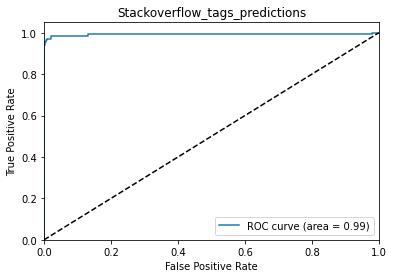

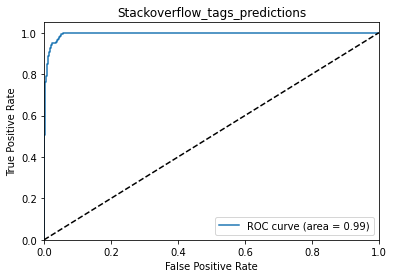

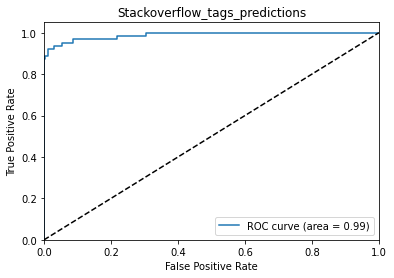

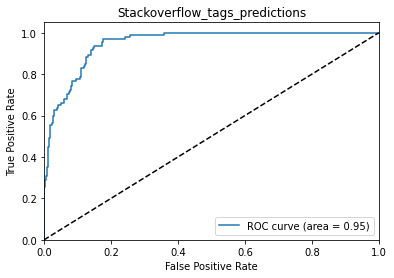

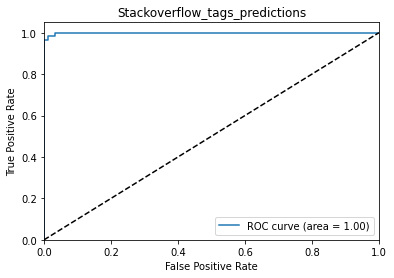

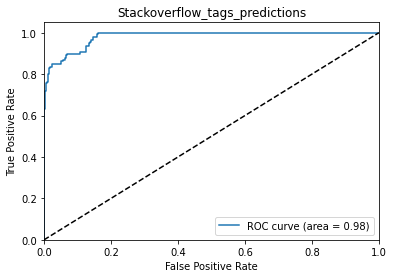

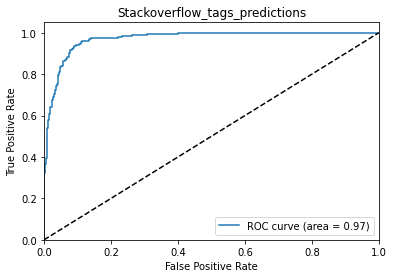

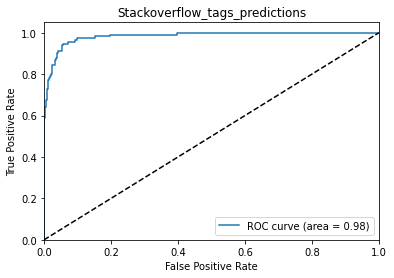

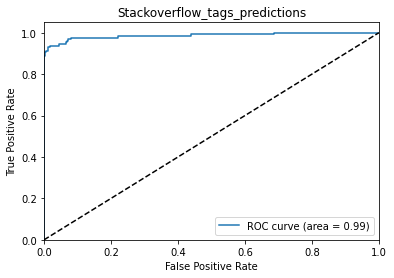

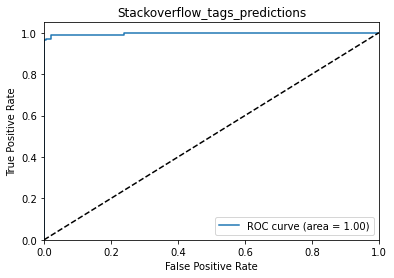

In [102]:
#Plotting Roc Curve
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Stackoverflow_tags_predictions')
    plt.legend(loc="lower right")
    plt.show()